Base case - Time: 12.333s, Energy: 131.463J
N satellites: [1, 2, 3, 4, 5, 6, 7, 8, 9]
Phi values: [0.  0.1 0.2 0.3 0.4 0.5 0.6 0.7 0.8 0.9 1.  1.1 1.2 1.3 1.4 1.5]
s_isl: 16.0
Computing cost grid...
Computing for 1 satellites...
Computing for 2 satellites...
Computing for 3 satellites...
Computing for 4 satellites...
Computing for 5 satellites...
Computing for 6 satellites...
Computing for 7 satellites...
Computing for 8 satellites...
Computing for 9 satellites...
Cost computation complete!
Time costs shape: (9, 16)
Energy costs shape: (9, 16)
Displaying phi values: [0.2 0.3 0.4 0.5 0.6 0.7 0.8 0.9 1. ]
Number of curves to display: 9
0 2 0.2
0 8.583333333333332
1 9.833333333333332
2 11.083333333333332
3 12.333333333333332
4 13.583333333333332
5 14.833333333333332
6 16.083333333333332
7 17.333333333333332
8 18.583333333333332
1 3 0.30000000000000004
0 9.583333333333332
1 11.458333333333332
2 13.333333333333332
3 15.208333333333332
4 17.083333333333332
5 18.958333333333332
6 20.833333333

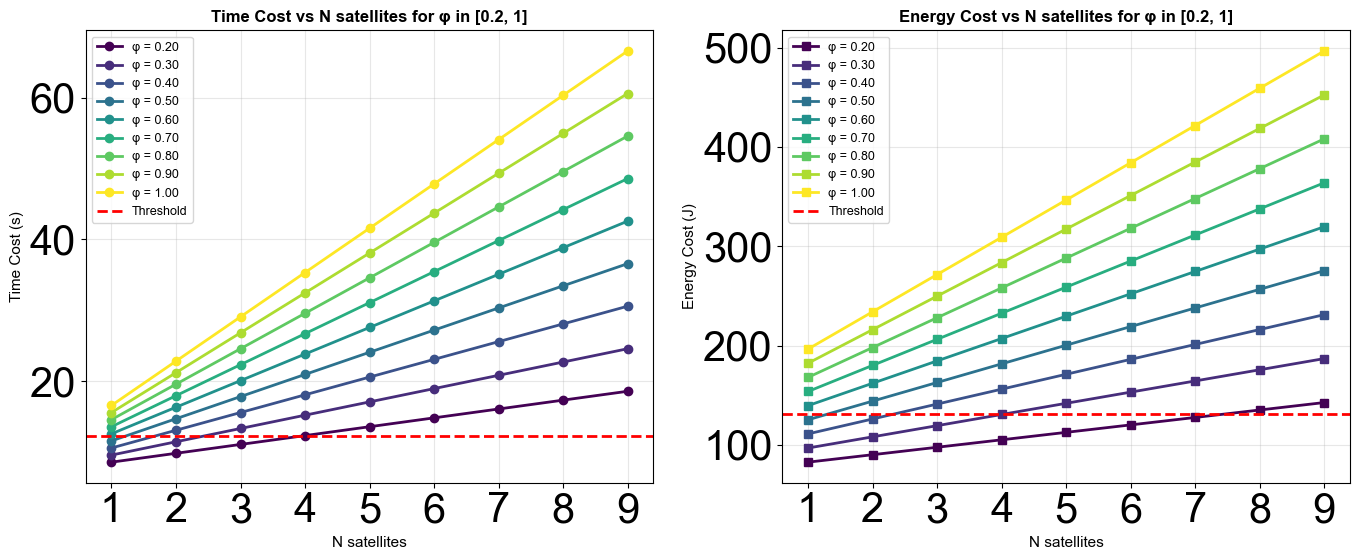

In [3]:
import numpy as np
import matplotlib.pyplot as plt

from matplotlib.colors import ListedColormap
from matplotlib.patches import Patch
from datetime import datetime

# Configure matplotlib for LaTeX rendering
plt.rcParams.update({
    'text.usetex': False,  # Disable LaTeX to use system fonts
    'font.family': 'sans-serif',
    'font.sans-serif': ['Arial'],  # Impact first, fallbacks
    'font.size': 20,
    'axes.labelsize': 25,
    'axes.titlesize': 25,
    'legend.fontsize': 25,
    'xtick.labelsize': 30,
    'ytick.labelsize': 30,
    'figure.titlesize': 30,
    'pgf.rcfonts': False,  # Use LaTeX default fonts for PGF
    'pgf.preamble': r'\usepackage{amsmath}\usepackage{amsfonts}'
})

from plot.multicurve import MultiCurvePlotter
from plot.log_dual_plot import LogDualPlot

from core.nodes.transmission_node import TransmissionNode
from core.nodes.computing_node import ComputingNode

with_legend = True
plot_precision = 1000

data_size = 100

config = {
    "base": {
        "obdh": {
            "speed": 30.0,
            "phi": 0.9,
            "energy_uptime": 1,
            "energy_io": 0.001
        },
        "ground_link": {
            "speed": 10.0,
            "energy": 5,
            "distance": 700
        }
    },
    "offloading": {
        "user_satellite": {
            "obdh": {
                "phi": None,
                "speed": None,
                "energy_uptime": None,
                "energy_io": None
            },
            "isl": {
                "speed": None,
                "energy": 3,
                "distance": 100
            }
        },
        "edge_node": {
            "edge_computer": {
                "phi": None,
                "speed": 300.0,
                "energy_uptime": 50,
                "energy_io": 0.001
            },
            "ground_link": {
                "speed": None,
                "energy": 5,
                "distance": 700
            }
        }
    }
}
base_obdh_speed = config['base']['obdh']['speed']
base_odbh_phi = config['base']['obdh']['phi']
base_obdh_energy_uptime = config['base']['obdh']['energy_uptime']
base_obdh_energy_io = config['base']['obdh']['energy_io']

# Base Case - calculate reference costs
base_time_cost = 0
base_energy_cost = 0

obc = ComputingNode(
    speed=base_obdh_speed,
    phi=base_odbh_phi
)

base_time_cost += obc.time_cost(data_size)
base_energy_cost += obc.energy_cost(
    data_size,
    energy_uptime=base_obdh_energy_uptime,
    energy_io=base_obdh_energy_io
)

d_out_obc = obc.process(data_size)

base_ground_link_speed = config['base']['ground_link']['speed']
base_ground_link_energy = config['base']['ground_link']['energy']
base_ground_link_distance = config['base']['ground_link']['distance']

ground_link = TransmissionNode(
    speed=base_ground_link_speed
)

base_time_cost += ground_link.time_cost(d_out_obc)
base_energy_cost += ground_link.energy_cost(
    d_out_obc,
    energy=base_ground_link_energy,
    distance=base_ground_link_distance
)

print(f"Base case - Time: {base_time_cost:.3f}s, Energy: {base_energy_cost:.3f}J")
# Define parameter ranges
n_satellites = range(1, 10, 1)
phi_values = np.arange(0.0, 1.6, 0.1)  # From 0 to 1.5 with 0.1 stride
s_isl = base_ground_link_speed * 1.6

print(f"N satellites: {list(n_satellites)}")
print(f"Phi values: {phi_values}")
print(f"s_isl: {s_isl}")
time_costs = [[] for _ in range(len(n_satellites))]
energy_costs = [[] for _ in range(len(n_satellites))]

# Offloading configuration
off_isl_energy = config['offloading']['user_satellite']['isl']['energy']
off_isl_distance = config['offloading']['user_satellite']['isl']['distance']

off_edge_computer_speed = config['offloading']['edge_node']['edge_computer']['speed']
off_edge_computer_energy_uptime = config['offloading']['edge_node']['edge_computer']['energy_uptime']
off_edge_computer_energy_io = config['offloading']['edge_node']['edge_computer']['energy_io']

off_ground_link_energy = config['offloading']['edge_node']['ground_link']['energy']
off_ground_link_distance = config['offloading']['edge_node']['ground_link']['distance']

print("Computing cost grid...")

# Pre-compute ISL costs (same for all iterations)
isl = TransmissionNode(speed=float(s_isl))
after_isl_iteration_time_cost = isl.time_cost(data_size)
after_isl_iteration_energy_cost = isl.energy_cost(
    data_size,
    energy=off_isl_energy,
    distance=off_isl_distance
)

d_out_isl = isl.process(data_size)

for i, n in enumerate(n_satellites):
    print(f"Computing for {n} satellites...")

    for j, phi_en in enumerate(phi_values):
        # Initialize costs with ISL transmission
        iteration_time_cost = after_isl_iteration_time_cost
        iteration_energy_cost = after_isl_iteration_energy_cost

        # First edge computer processing
        edge_computer = ComputingNode(
            speed=off_edge_computer_speed,
            phi=phi_en
        )

        iteration_time_cost += edge_computer.time_cost(d_out_isl)
        iteration_energy_cost += edge_computer.energy_cost(
            d_out_isl,
            energy_uptime=off_edge_computer_energy_uptime,
            energy_io=off_edge_computer_energy_io
        )

        d_out_ec = edge_computer.process(d_out_isl)

        # Additional satellites processing (n-1 more hops)
        if n > 1:
            for hop in range(n - 1):
                # ISL transmission to next satellite
                en_isl = TransmissionNode(speed=float(s_isl))
                iteration_time_cost += en_isl.time_cost(d_out_ec)
                iteration_energy_cost += en_isl.energy_cost(
                    d_out_ec,
                    energy=off_isl_energy,
                    distance=off_isl_distance
                )

                d_out_ec = en_isl.process(d_out_ec)

        # Final ground link transmission
        ground_link = TransmissionNode(speed=float(base_ground_link_speed))
        iteration_time_cost += ground_link.time_cost(d_out_ec)
        iteration_energy_cost += ground_link.energy_cost(
            d_out_ec,
            energy=off_ground_link_energy,
            distance=off_ground_link_distance
        )

        # Store costs
        time_costs[i].append(iteration_time_cost)
        energy_costs[i].append(iteration_energy_cost)

print("Cost computation complete!")
print("Time costs shape:", np.array(time_costs).shape)
print("Energy costs shape:", np.array(energy_costs).shape)

# Convert to numpy arrays for easier indexing
time_costs_array = np.array(time_costs)
energy_costs_array = np.array(energy_costs)

# Select phi values to display (between 0.4 and 1.2)
phi_min_display = 0.2
phi_max_display = 1
phi_mask = (phi_values >= phi_min_display) & (phi_values <= phi_max_display)
phi_to_display = phi_values[phi_mask]
phi_indices = np.where(phi_mask)[0]

print(f"Displaying phi values: {phi_to_display}")
print(f"Number of curves to display: {len(phi_to_display)}")

# Create a figure with 2 subplots side by side
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

# Define colors for different phi values
colors = plt.cm.viridis(np.linspace(0, 1, len(phi_to_display)))

# First plot - Time Cost
for idx, (j, phi_en) in enumerate(zip(phi_indices, phi_to_display)):
    ax1.plot(n_satellites, time_costs_array[:, j], marker='o',
             color=colors[idx], label=f'φ = {phi_en:.2f}', linewidth=2)
    print(idx, j, phi_en)
    for idx, v in enumerate(time_costs_array[:, j]):
        print(idx, v)

ax1.axhline(y=base_time_cost, color='red', linestyle='--', linewidth=2, label='Threshold')
ax1.set_xlabel('N satellites', fontsize=11)
ax1.set_ylabel('Time Cost (s)', fontsize=11)
ax1.set_title(f'Time Cost vs N satellites for φ in [{phi_min_display}, {phi_max_display}]',
              fontsize=12, fontweight='bold')
ax1.set_xticks(n_satellites)
ax1.grid(True, alpha=0.3)
ax1.legend(loc='best', fontsize=9)

# Second plot - Energy Cost
for idx, (j, phi_en) in enumerate(zip(phi_indices, phi_to_display)):
    ax2.plot(n_satellites, energy_costs_array[:, j], marker='s',
             color=colors[idx], label=f'φ = {phi_en:.2f}', linewidth=2)

ax2.axhline(y=base_energy_cost, color='red', linestyle='--', linewidth=2, label='Threshold')
ax2.set_xlabel('N satellites', fontsize=11)
ax2.set_ylabel('Energy Cost (J)', fontsize=11)
ax2.set_title(f'Energy Cost vs N satellites for φ in [{phi_min_display}, {phi_max_display}]',
              fontsize=12, fontweight='bold')
ax2.set_xticks(n_satellites)
ax2.grid(True, alpha=0.3)
ax2.legend(loc='best', fontsize=9)

# Adjust layout to prevent overlap
plt.tight_layout()

# Display the plots
plt.show()